## Read in Data

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
tech_projects = pickle.load(open('data/2015_06_04_tech_projects.p','rb'))

In [3]:
# read in data
#comments_db = pickle.load(open('data/2015_06_04_comments_db_short.p','rb'))
#total_comments_db = pickle.load(open('data/2015_06_04_comments_dbt_short.p','rb'))
comments_db = pickle.load(open('data/2015_06_06_comments_db.p','rb'))
total_comments_db = pickle.load(open('data/2015_06_06_comments_dbt.p','rb'))

In [4]:
comment_keys = comments_db.keys()
len(comment_keys)

2899

## Define NLP functions

In [5]:
import nltk
from nltk import word_tokenize
stemmer = nltk.stem.porter.PorterStemmer()

In [24]:
# define custom tags
# add: fucking, wait, sorry, rude, "no answer", "no response", problem, complaint, mistake, unprofessional, wtf
good_words = map(stemmer.stem, ['great', 'cool', 'fast', 'awesome', 'excited', 'shipped', 'received'])
#bad_words = map(stemmer.stem, ['delay','late','refund','worst','awful', 'bad', 'fraud','dead','cancel','shame','stole','scam']) # add 'cancel', shame, stole
bad_words = map(stemmer.stem, ['delay','late','refund','worst','awful', 'bad', 'fraud','dead','cancel','shame','stole','scam','cancel', 'shame', 'stole','wtf','unprofessional','mistake','fucking','wait','sorry','rude','complaint', 'mistake'])

In [10]:
def get_comment_sentiment_simple(comment, s, good_words, bad_words):
    tokenized = word_tokenize(comment.lower())
    stemmed = map(s.stem, tokenized)
    word_count = len(stemmed)
    
    # simple: count positives and negatives
    count = 0
    for word in stemmed:
        if word in good_words:
            count = count + 1
        if word in bad_words:
            count = count - 1
    return count, word_count

## Simple web sentiment analysis

In [221]:
def get_comment_list(proj):
    comment_list = []
    date_list = []
    for key in proj.keys():
        comment_list.append(proj[key]['comment'])
        date_list.append(proj[key]['date'])
    return comment_list, date_list

In [246]:
def get_comment_sentiment_web(comment_list):
    comments_combined = []
    idx = []
    for ii, c in enumerate(comment_list):
        c_split = c.split('.')
        first_line = c_split[0]
        comments_combined.append(first_line)
        idx.append(ii)
    
    # write to file
    comment_file = 'comments.txt'
    f = open(comment_file,'wb')
    for c in comments_combined:
        f.write("%s\n" % c)
    f.close()
    
    # execute command
    sentiment_file = 'comments_sentiments.txt'
    os.system('curl --data-binary @%s "http://www.sentiment140.com/api/bulkClassify" > %s' % (comment_file,sentiment_file))
    df = pd.DataFrame.from_csv(sentiment_file,header=None)
    return df

In [314]:
def get_project_sentiment_web(comments_db, key):
    proj = comments_db[key]
    comment_list, date_list = get_comment_list(proj)
    df_sentiment = get_comment_sentiment_web(comment_list)     
    df_sentiment.rename(columns={1:'comment'},inplace=True)
    df_sentiment['date'] = date_list
    df_sentiment['key'] = key
    
    # web sentiments are scored as 0:negative, 2:neutral, 4:positive
    # rescale so that negative = -1, neutral = 0, positive = +1
    df_sentiment['web_sentiment'] = df_sentiment.index.values/2 - 1
    
    # add integer index
    idx = range(0, len(df_sentiment))
    df_sentiment['i'] = idx
    df_sentiment.set_index(keys='i',drop=True,inplace=True)
    
    return df_sentiment

In [315]:
d = get_project_sentiment_web(comments_db, keys[0])
d.head()

,comment,date,key,web_sentiment
i,,,,
0,Anyone know the status of this project?,"April 11, 2011",776496128,0
1,Congrates!,"November 22, 2010",776496128,0
2,This is great,"November 19, 2010",776496128,0
3,This is a great project! Most of the things th...,"October 24, 2010",776496128,0
4,My proposal is that I will pledge $100 if you ...,"October 21, 2010",776496128,0


###Compute web sentiment for all projects

In [323]:
import time

key_list = np.unique(keys)
df_sentiment_web = None
for ii, k in enumerate(key_list):
    try:
        df0 = get_project_sentiment_web(comments_db, k)

        if df_sentiment_web is None:
            df_sentiment_web = df0
        else:
            df_sentiment_web = pd.concat([df_sentiment_web, df0])

        print 'Ran project %d of %d' % (ii, len(key_list))
    except:
        print 'Failed on key %s' % str(k)
    time.sleep(2) # avoid upsetting API

Ran project 0 of 159
Ran project 1 of 159
Ran project 2 of 159
Ran project 3 of 159
Ran project 4 of 159
Ran project 5 of 159
Ran project 6 of 159
Ran project 7 of 159
Ran project 8 of 159
Ran project 9 of 159
Ran project 10 of 159
Ran project 11 of 159
Ran project 12 of 159
Failed on key 136125612
Ran project 14 of 159
Ran project 15 of 159
Ran project 16 of 159
Ran project 17 of 159
Ran project 18 of 159
Ran project 19 of 159
Ran project 20 of 159
Ran project 21 of 159
Ran project 22 of 159
Ran project 23 of 159
Ran project 24 of 159
Ran project 25 of 159
Failed on key 276100515
Ran project 27 of 159
Ran project 28 of 159
Ran project 29 of 159
Ran project 30 of 159
Ran project 31 of 159
Ran project 32 of 159
Ran project 33 of 159
Ran project 34 of 159
Ran project 35 of 159
Failed on key 374202876
Ran project 37 of 159
Ran project 38 of 159
Failed on key 425828491
Ran project 40 of 159
Ran project 41 of 159
Ran project 42 of 159
Ran project 43 of 159
Ran project 44 of 159
Ran project 

## Stanford Parser

In [151]:
cd '/NLP/corenlp-python-3.4.1-1/'

[Errno 2] No such file or directory: '/NLP/corenlp-python-3.4.1-1/'
/Users/alexmccauley/Documents/Insight_2015/Project/Kickstarter/NLP/corenlp-python-3.4.1-1


In [152]:
#cd ('/Users/alexmccauley/Documents/Insight_2015/Project/Kickstarter/NLP/corenlp-python-3.4.1-1')
from corenlp import StanfordCoreNLP
corenlp_dir = '../stanford-corenlp-full-2015-04-20'
corenlp = StanfordCoreNLP(corenlp_dir)

##Process comments

In [45]:
comments_db[comments_db.keys()[0]][0]

{'comment': u"What an awesome tool and you are just the person to design it. This will become a valuable resource for the transgender community as well as their allies. I'm so proud of the work you are doing <3",
 'date': u'November 15, 2013',
 'index': 0,
 'sentiment': 1,
 'user': u'James E. Vivian (deleted)',
 'word_count': 42}

In [25]:
from __future__ import division

n_keys = len(comments_db.keys())
count = 0
for key in comments_db:
    count = count + 1
    if count % int(round(n_keys/10)) == 0:
        print '%d percent complete' % int( 100 * count / n_keys) 
    # individual projects
    for key_c in comments_db[key]:
        # individual comments
        #try:
        comment = comments_db[key][key_c]['comment']
        if len(comment) == 0:
            s = 0
            word_count = 1
        else:
            s, word_count = get_comment_sentiment_simple(comment,stemmer,good_words,bad_words)
        comments_db[key][key_c]['sentiment'] = s
        comments_db[key][key_c]['word_count'] = word_count # number of stemmed tokens
        
        #except:
        #    print 'Failed at key %s, comment %s' % (str(key), str(key_c))
        #    break

10 percent complete
20 percent complete
30 percent complete
40 percent complete
50 percent complete
60 percent complete
70 percent complete
80 percent complete
90 percent complete


##Breakpoint

In [29]:
pickle.dump({'comments':comments_db,'good_words':good_words,'bad_words':bad_words, 'dataframe_with_sents':df}, open('2015-06-10-comments_db_with_simple_sentiments_2.p','wb'))

In [27]:
# format comment dates
# convert to dataframe

from dateutil import parser
import pandas as pd

# dataframe: cols = project_key, comment_number, date, comment_text, sentiment_rating
keys = []
idx = []
dates = []
text = []
sents = []

for key in comments_db:
    proj = comments_db[key]
    for ii, key_c in enumerate(proj):
        if len(proj[key_c]) > 0:
            
            try:
                dates.append(parser.parse(proj[key_c]['date']))
            except ValueError:
                # weird value in date; substitute with nearest neighbors
                try:
                    dates.append(parser.parse(proj[key_c-1]['date']))
                except KeyError:
                    try:
                        dates.append(parser.parse(proj[key_c+1]['date']))
                    except KeyError:
                        # must be only one comment, in which case the date is not that important
                        dates.append(parser.parse('January 1 1900')) # obvious outlier
                        
            keys.append(key) # project key
            idx.append(ii) # comment number (ordered)
            text.append(proj[key_c]['comment'])
            sents.append(proj[key_c]['sentiment'])
            #except:
                # bad date
               # print 'Found bad date: key %s, ii = %d, date = %s' % (str(key),ii,str(proj[key_c]['date']))
                #continue
               # break

df = pd.DataFrame()
df['keys'] = keys
df['idx'] = idx
df['dates'] = dates
df['text'] = text
df['sents'] = sents

In [49]:
tech_projects[tech_projects.keys()[0]]['slug']

u'transgender-murder-violence-and-suicide-website'

In [28]:
df.shape

(491078, 5)

In [59]:
df.head(3)

,keys,idx,dates,text,sents
0,1842798593,0,2013-11-15,What an awesome tool and you are just the pers...,1
1,1842798593,1,2013-11-07,"Awesome to see your past your goal, good luck ...",0
2,1842798593,2,2013-11-07,Organizations like the Pacific Justice Institu...,0


In [ ]:
# save dataframe


##Collect vital stats on sentiment

In [32]:
df.sort(columns='sents',ascending=True).head()

,keys,idx,dates,text,sents
96177,1735427296,1695,2014-05-13,Refund refund refund Refund refund refund Refu...,-106
96185,1735427296,1703,2014-05-11,Refund Refund Refund Refund Refund Refund RRef...,-93
351340,648729703,669,2013-10-17,Waiting. Waiting. Waiting. Waiting. Waiting. W...,-22
371860,941348329,574,2014-04-19,"Terry Gauchat Feb 7, 2014 Per Project Update #...",-21
375149,469832614,674,2015-03-03,"Here is my view, probably expressed in too man...",-20


### Campaign duration

In [30]:
df_dates = df[['keys','dates']].copy(deep=True)
df_dates_grouped = df_dates.groupby('keys')#.aggregate(np.min,np.max)
df_dates_max_min = df_dates_grouped.agg([np.min, np.max])
df_dates_max_min.columns = df_dates_max_min.columns.droplevel(0)
df_dates_max_min['duration'] = df_dates_max_min['amax'] - df_dates_max_min['amin']
df_dates_max_min = df_dates_max_min.reset_index(level=0)

In [17]:
df_dates_max_min.head()

,keys,amin,amax,duration
0,182943,2014-09-18,2014-11-20,63 days
1,422207,2014-01-23,2014-05-13,110 days
2,600658,2014-08-05,2015-01-26,174 days
3,727286,2009-04-25,2010-05-13,383 days
4,1450156,2015-02-24,2015-04-27,62 days


## Total project sentiment / comment

In [33]:
#total_project_sentiment = df.groupby(keys) 
from __future__ import division
import numpy as np

get_neg = lambda x: float(x < 0)*-1
get_pos = lambda x: float(x > 0)*1
get_neutral = lambda x: float(x == 0)
def get_sign(x):
    if x == 0:
        return x
    else:
        return x / np.abs(x)

c = df[['keys','sents']].copy(deep=True)
c['sent_neg'] = c['sents'].apply(get_neg)
c['sent_pos'] = c['sents'].apply(get_pos)
c['sent_neutral'] = c['sents'].apply(get_neutral)
c['sent_average'] = c['sents'].apply(get_sign)

total_sents = c.groupby('keys').apply(np.mean)
total_sents = total_sents.sort('sent_neg')
total_sents['fraction'] = -total_sents['sent_neg'] / (total_sents['sent_pos'] -total_sents['sent_neg'])
total_sents.sort('sent_average',ascending=False)

total_sents.head()

,keys,sents,sent_neg,sent_pos,sent_neutral,sent_average,fraction
keys,,,,,,,
331905521,331905521,-1,-1,0,0,-1,1
6872440,6872440,-1,-1,0,0,-1,1
161868950,161868950,-1,-1,0,0,-1,1
541253007,541253007,-1,-1,0,0,-1,1
681627866,681627866,-1,-1,0,0,-1,1


In [19]:
# convert total comments_db to a dataframe
idx = []
n_total = []
for key in total_comments_db:
    idx.append(key)
    n_total.append(total_comments_db[key])
df_total_comments = pd.DataFrame()
df_total_comments['keys'] = idx
df_total_comments['total_comments'] = n_total

## Merge lots of data together

In [20]:
total_sents_comm = pd.merge(left=total_sents, right=df_total_comments, how='inner', on='keys')
total_sents_c_d = pd.merge(left=total_sents_comm, right=df_dates_max_min[['keys', 'duration']], how='inner', on='keys')

In [18]:
total_sents_c_d.head()

,keys,sents,sent_neg,sent_pos,sent_neutral,sent_average,fraction,total_comments,duration
0,1568338369,-0.84,-0.82,0.00,0.18,-0.82,1.000000,2160,38 days
1,909702674,-3.26,-0.80,0.04,0.16,-0.76,0.952381,858,73 days
2,1480401218,-0.50,-0.50,0.00,0.50,-0.50,1.000000,2,161 days
3,1730155176,-0.50,-0.50,0.00,0.50,-0.50,1.000000,2,36 days
4,1753626841,-0.50,-0.50,0.00,0.50,-0.50,1.000000,2,19 days


In [3]:
import pickle
d=pickle.load(open('data/sentiment_data_06_08.p','rb'))

In [21]:
# save data
pickle.dump({'data_aggregated':total_sents_c_d, 'data':df, 'data_dates':df_dates},open('data/sentiment_data_06_10.p','wb'))

## Determine fraction of "negative"/"neutral"/"positive" projects

In [173]:
total_sents_c_d.iloc[0]['duration'] > pd.tslib.Timedelta(value=72, unit='D')

True

In [176]:
# number of overall negative threads with > 10 comments and greater than 60 day duration
min_duraction = pd.tslib.Timedelta(value=60, unit='D')
total_sents_c_d[(total_sents_c_d['sent_average'] < 0) & (total_sents_c_d['total_comments']>10) & (total_sents_c_d['duration']>min_duraction)].shape

(76, 9)

In [178]:
total_sents_c_d[(total_sents_c_d['total_comments']>10) & (total_sents_c_d['duration'] > min_duraction)].shape

(1675, 9)

In [179]:
76/1675

0.04537313432835821

In [265]:
total_sents_screened = total_sents_c_d[(total_sents_c_d['total_comments']>10) & (total_sents_c_d['duration']>min_duraction)]

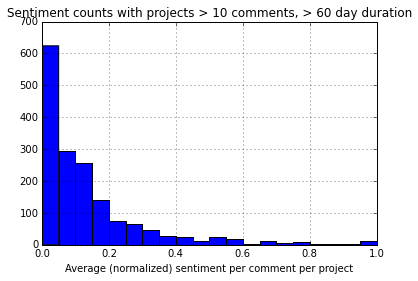

In [273]:
total_sents_screened['fraction'].hist(bins=20);
plt.xlabel('Average (normalized) sentiment per comment per project');
plt.title('Sentiment counts with projects > 10 comments, > 60 day duration')

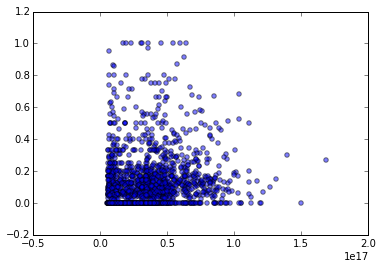

In [267]:
plt.scatter(total_sents_screened['duration'].apply(lambda x:x.astype(int)),total_sents_screened['fraction'],alpha=0.5)

In [ ]:
1+1

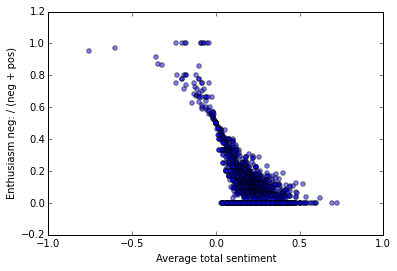

In [270]:
plt.scatter(total_sents_screened['sent_average'],total_sents_screened['fraction'],alpha=0.5);
plt.xlabel('Average total sentiment');plt.ylabel('Enthusiasm neg: / (neg + pos)')

In [206]:
total_sents_screened.sort(columns='sent_average',ascending=False).head(4)

,keys,sents,sent_neg,sent_pos,sent_neutral,sent_average,fraction,total_comments,duration
1624,1971628828,1.25,0.00,0.722222,0.277778,0.722222,-0.000000,36,283 days
2142,654352705,1.00,0.00,0.692308,0.307692,0.692308,-0.000000,13,207 days
1051,394474393,0.76,-0.02,0.640000,0.340000,0.620000,0.058824,669,62 days
2627,1189473009,0.88,0.00,0.600000,0.400000,0.600000,-0.000000,85,462 days


## Investigate time-dependence of negative sentiment

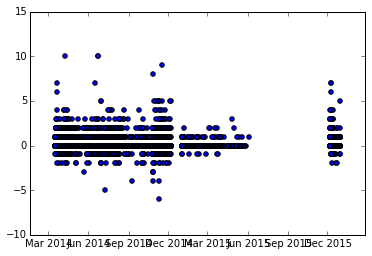

In [242]:
t = df[['keys','sents','dates']][df['keys']==1152735261]
y = t['sents'].values; x = t['dates'].values;
plt.scatter(x,y);

In [243]:
total_sents_screened[total_sents_screened['keys']==1152735261]

,keys,sents,sent_neg,sent_pos,sent_neutral,sent_average,fraction,total_comments,duration
879,1152735261,0.12845,-0.023526,0.119514,0.85696,0.095988,0.027453,16639,654 days


In [225]:
inconsistent_keys = []
key_lengths = []
for key in comments_db:
    if len(comments_db[key].keys()) < total_comments_db[key]:
        inconsistent_keys.append(key)
        key_lengths.append(len(comments_db[key].keys()))

In [230]:
a = np.array(key_lengths)

In [234]:
key_lengths[a.argmax()]

16450

In [235]:
inconsistent_keys[a.argmax()]

1152735261

In [62]:
comments_db.keys()[1]

509500187

In [241]:
tech_projects[1152735261]['urls']['web']['project']

u'https://www.kickstarter.com/projects/1003614822/ponomusic-where-your-soul-rediscovers-music?ref=discovery'

In [63]:
len(comments_db[509500187])

4

In [52]:
comment_data = pickle.load(open('data/sentiment_data_06_08.p','rb'))

In [59]:
comment_data['data'].iloc[0]['idx']

0